In [1]:
import os
import besos
from besos import sampling
from besos import eppy_funcs as ef
from besos import eplus_funcs as ep
from besos.problem import EPProblem
from besos.evaluator import EvaluatorEP
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist, DependentParameter, CategoryParameter
from besos.objectives import MeterReader,time_series_values,EPResults
from besos.optimizer import NSGAII, df_solution_to_solutions
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot

In [2]:
# Open the IDF file
idf_1 = "/home/ict4bd/Desktop/ict4building/DesignBuilderModel/1_layer_window.idf"
idf_2 = "/home/ict4bd/Desktop/ict4building/DesignBuilderModel/2_layer_window.idf"
idf_3 = "/home/ict4bd/Desktop/ict4building/DesignBuilderModel/3_layer_window.idf"
weather_file = '/home/ict4bd/Desktop/ict4building/Requirements/CHE_Geneva.067000_IWEC/CHE_Geneva.067000_IWEC.epw'

In [3]:
# check the version if 8.X then convert it using E+
# ep.get_idf_version(building)

In [5]:
# get a list of the Name property of all IDF objects of class MATERIAL
# !- Design Flow Rate is for CNV 
# !- Setpoint is for Shading control
# Insulation thickness is espressed in meters
'''

for shading in building1.idfobjects["WindowShadingControl"]:
    print(shading)
for ventilation in building1.idfobjects["ZoneVentilation:DesignFlowRate"]:
    print(ventilation)
for material in building1.idfobjects["Material"]:
    print(material)
    
'''


WindowShadingControl,
    1001-Block1:Zone3,        !- Name
    Block1:Zone3,             !- Zone Name
    1,                        !- Shading Control Sequence Number
    ExteriorBlind,            !- Shading Type
    2001,                     !- Construction with Shading Name
    OnIfHighZoneAirTemperature,    !- Shading Control Type
    TM59_Kitchen_Occ,         !- Schedule Name
    9.52,                     !- Setpoint
    Yes,                      !- Shading Control Is Scheduled
    No,                       !- Glare Control Is Active
    ,                         !- Shading Device Material Name
    FixedSlatAngle,           !- Type of Slat Angle Control for Blinds
    ,                         !- Slat Angle Schedule Name
    0,                        !- Setpoint 2
    Block1:Zone3,             !- Daylighting Control Object Name
    Sequential,               !- Multiple Surface Control Type
    Block1:Zone3_Wall_5_0_0_0_0_0_Win;    !- Fenestration Surface 1 Name


WindowShadingCon

In [3]:
## Set up evaluator
# Load Building

building = ef.get_building(idf_1)

# Parameter Space
parameters = []

orientation = FieldSelector(class_name='Building', field_name='North Axis')
orientation_descriptor = CategoryParameter(options=[0, 90, 180, 270])

insulation = FieldSelector(class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.O792', 
                           field_name='Thickness')
insulation_descriptor = RangeParameter(min_val = 0.01, max_val=0.5) 

shading = FieldSelector(class_name='WindowShadingControl',field_name='Setpoint')
shading_descriptor = RangeParameter(min_val = 0, max_val=30) 

ventilation = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',field_name='Design Flow Rate')
ventilation_descriptor = CategoryParameter(options=[0, 0.12])


# parameters = [Orientation, ventilation, shading, insulation, wwr]
parameters.append(Parameter(selector=orientation, 
                            value_descriptor=orientation_descriptor,
                            name='Orientation'))

parameters.append(Parameter(selector=ventilation,
                            value_descriptor=ventilation_descriptor,
                            name='Ventilation'))

parameters.append(Parameter(selector=shading,
                            value_descriptor=shading_descriptor,
                            name='Shading'))

parameters.append(Parameter(selector=insulation,
                            value_descriptor=insulation_descriptor,
                            name='Insulation Thickness'))

parameters.append(wwr(RangeParameter(0.1,0.9))) 

# Objectives of our problem which is to minimize the TOTAL COMSUMPTION
objectives = ['Electricity:Facility','DistrictCooling:Facility', 'DistrictHeating:Facility']

# problem = parameters + objectives
besos_problem = EPProblem(parameters, objectives)

# EPProblem vs EvaluatorEP = problem + building + weather
evaluator = EvaluatorEP(besos_problem, building, out_dir='outputdir', err_dir='outputdir', epw_file=weather_file) 

# evaluate the problem with some possible values change sample number
samples = sampling.dist_sampler(sampling.lhs, besos_problem, num_samples=1)

/home/ict4bd/py3/lib/python3.8/site-packages/besos/evaluator.py:659: FutureWarning: epw_file has been deprecated and will be removed in the future. Use epw instead.
  warn(


In [4]:
# return dataframe with results described in objectives
outputs = evaluator.df_apply(samples, keep_input=True)

In [5]:
# Q is kWh / m2
total_area= 0
for Zones in building.idfobjects["Zone"]:
    total_area += float(Zones.checkrange("Floor_Area")) 

#
outputs['total (Q)'] = outputs[objectives].sum(axis=1) /3.6e6 /total_area 
outputs.to_csv("demo.csv")

DATAVISUALIZATION

Text(0, 0.5, 'DistrictHeating:Facility')

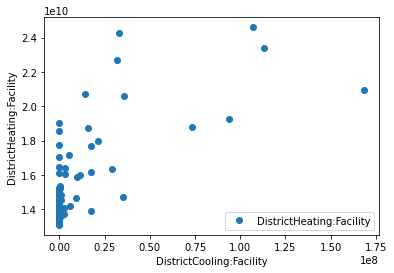

In [6]:
df_out1 = pd.read_csv("1_layer.csv", index_col=0)
df_out2 = pd.read_csv("2_layer.csv", index_col=0)
df_out3 = pd.read_csv("3_layer.csv", index_col=0)

# organize the data
_ = df_out3.plot(x=objectives[1], y=objectives[2], style = 'o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])

In [8]:
df_out1.describe()

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,135.000000,0.060000,15.017222,0.254981,0.499812,5.772445e+09,1.202575e+07,1.723931e+10,136.469859
std,101.129979,0.060302,8.697275,0.142077,0.231970,1.135827e+06,2.640389e+07,2.747298e+09,16.397513
min,0.000000,0.000000,0.289647,0.012320,0.103657,5.768195e+09,0.000000e+00,1.352184e+10,114.367291
25%,67.500000,0.000000,7.651680,0.132664,0.303100,5.772389e+09,0.000000e+00,1.536401e+10,125.285358
50%,135.000000,0.060000,14.991087,0.254987,0.500136,5.772984e+09,9.852076e+05,1.668783e+10,133.182124
75%,202.500000,0.120000,22.549686,0.375708,0.697735,5.773034e+09,1.225211e+07,1.818489e+10,142.009980
max,270.000000,0.120000,29.869867,0.496884,0.895863,5.773034e+09,1.689500e+08,2.868625e+10,204.985384


In [9]:
df_out1.corr()

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
Orientation,1.000000,-0.143108,0.068268,-0.031468,-0.078729,-0.478543,0.010905,0.028543,0.028253
Ventilation,-0.143108,1.000000,-0.074017,-0.088268,0.152833,0.169219,-0.310153,0.063574,0.060244
Shading,0.068268,-0.074017,1.000000,-0.058426,-0.181793,0.031783,-0.103875,-0.153044,-0.152965
Insulation Thickness,-0.031468,-0.088268,-0.058426,1.000000,-0.019177,0.037083,-0.474299,-0.740427,-0.739820
Window to Wall Ratio,-0.078729,0.152833,-0.181793,-0.019177,1.000000,-0.393086,0.114931,0.278306,0.277318
Electricity:Facility,-0.478543,0.169219,0.031783,0.037083,-0.393086,1.000000,-0.107735,-0.159039,-0.158558
DistrictCooling:Facility,0.010905,-0.310153,-0.103875,-0.474299,0.114931,-0.107735,1.000000,0.728772,0.733235
DistrictHeating:Facility,0.028543,0.063574,-0.153044,-0.740427,0.278306,-0.159039,0.728772,1.000000,0.999979
total (Q),0.028253,0.060244,-0.152965,-0.739820,0.277318,-0.158558,0.733235,0.999979,1.000000


In [10]:
df_out2.describe()

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,135.000000,0.060000,14.984745,0.254915,0.499758,5.772485e+09,7.690283e+06,1.527053e+10,124.774707
std,101.129979,0.060302,8.707564,0.142153,0.232328,1.086555e+06,2.038892e+07,2.585748e+09,15.423228
min,0.000000,0.000000,0.160210,0.012307,0.100662,5.768467e+09,0.000000e+00,1.318530e+10,112.372556
25%,67.500000,0.000000,7.471839,0.133565,0.298932,5.772548e+09,0.000000e+00,1.379135e+10,115.964133
50%,135.000000,0.060000,15.128576,0.254697,0.496856,5.773000e+09,0.000000e+00,1.426293e+10,118.757556
75%,202.500000,0.120000,22.404417,0.375339,0.695308,5.773034e+09,1.884491e+06,1.560489e+10,126.794727
max,270.000000,0.120000,29.806117,0.496901,0.896706,5.773034e+09,1.144030e+08,2.666045e+10,192.611074


In [11]:
df_out3.describe()

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,135.000000,0.060000,15.000167,0.255186,0.500294,5.772360e+09,8.822823e+06,1.523806e+10,124.588245
std,101.129979,0.060302,8.699941,0.142111,0.231995,1.240614e+06,2.595322e+07,2.484151e+09,14.832368
min,0.000000,0.000000,0.050182,0.014554,0.105726,5.768473e+09,0.000000e+00,1.308094e+10,111.753901
25%,67.500000,0.000000,7.511767,0.133171,0.304106,5.772513e+09,0.000000e+00,1.372360e+10,115.563869
50%,135.000000,0.060000,14.901200,0.255122,0.502968,5.772987e+09,0.000000e+00,1.428781e+10,118.903656
75%,202.500000,0.120000,22.362118,0.374712,0.696138,5.773034e+09,1.395901e+06,1.546641e+10,125.908989
max,270.000000,0.120000,29.837162,0.497998,0.898523,5.773034e+09,1.683386e+08,2.460125e+10,180.671762


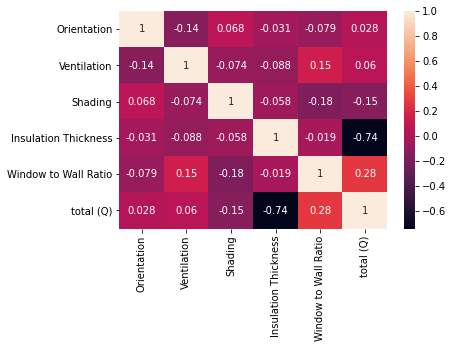

In [12]:
_ = heatmap(df_out1[["Orientation","Ventilation","Shading","Insulation Thickness","Window to Wall Ratio","total (Q)"]].corr(),annot=True)

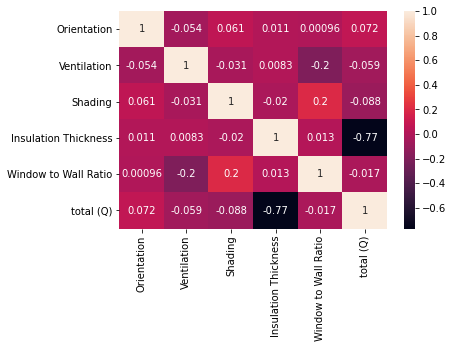

In [13]:
_ = heatmap(df_out2[["Orientation","Ventilation","Shading","Insulation Thickness","Window to Wall Ratio","total (Q)"]].corr(),annot=True)

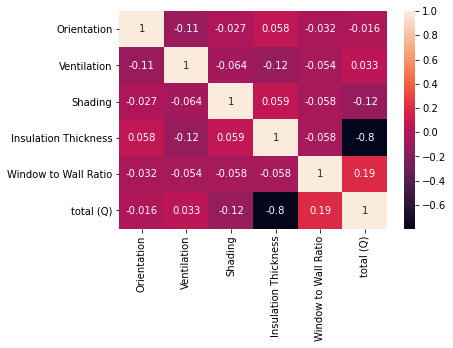

In [14]:
_ = heatmap(df_out3[["Orientation","Ventilation","Shading","Insulation Thickness","Window to Wall Ratio","total (Q)"]].corr(),annot=True)

The total Q value is most correlated with heating cooling insulation thickness and wwr in absolute terms

In [32]:
n1 = df_out1
n1[n1['total (Q)']==n1['total (Q)'].min()]

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
34,90,0.0,11.801973,0.449956,0.103657,5.773028e+09,0.0,1.352184e+10,114.367291


In [33]:
n2 = df_out2
n2[n2['total (Q)']==n2['total (Q)'].min()]

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
61,180,0.12,2.752663,0.453251,0.180006,5.773034e+09,0.0,1.318530e+10,112.372556


In [34]:
n3 = df_out3
n3[n3['total (Q)']==n3['total (Q)'].min()]

,Orientation,Ventilation,Shading,Insulation Thickness,Window to Wall Ratio,Electricity:Facility,DistrictCooling:Facility,DistrictHeating:Facility,total (Q)
34,90,0.0,9.514906,0.435923,0.105726,5.773030e+09,0.0,1.308094e+10,111.753901


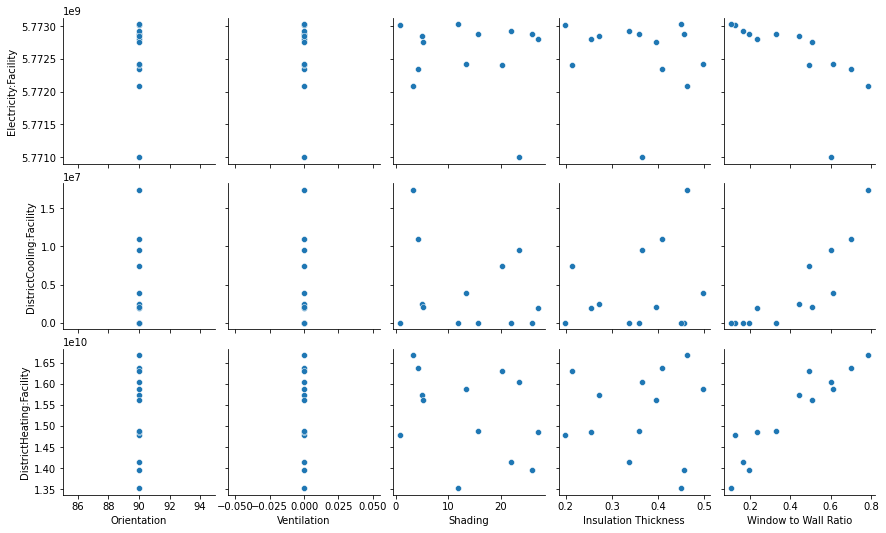

In [35]:
new_df=df_out1[df_out1["Orientation"]==90]

_=pairplot(new_df[new_df["Ventilation"]==0],x_vars=samples.columns, y_vars=objectives, kind="scatter")

The current simulation give us the best solution when the Windows is a 3 layer window with wwr 0.106, high insulation thickness 43 cm, shading setpoint to 10 degree and without ventilation with longest side facing south
inside the outdir there is the last simulation with 3 layer windows